### Loading Required Libraries

In [1]:
# import the necessary libraries

from modules import PreProcessing, functions
from sqlite3 import connect 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain
from collections import Counter
import nltk
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn import svm

# to ensure all changes are reflected 
# in-case jupyter notebook was already oppened

from importlib import reload
reload(PreProcessing)
reload(functions)

project_dir = 'C:/Users/OscarGil/Desktop/Project_509'
#project_dir = '/Users/nima/repository/Project_509'

### Section 1 - Create a Suport vector machine 

In [2]:
databse_file = 'database.db'
main = connect(databse_file)

sql_statement_laod_data = '''
SELECT a.*
    ,  b.star
FROM review_tokens as a
join reviews as b
    on a.id = b.id
'''

df = pd.read_sql_query(sql_statement_laod_data, main)

# Convert 'star' values to strings
df['star'] = df.star.astype(int).astype(str)

# Keep original tokens for SVM
df['raw_tokens'] = df['tokens']

# create a new column that holds tokens of clean_sentence
df['tokens'] = df['tokens'].apply(lambda x: x.split(' '))
df.sample(5)

,index,id,course_name,tokens,star,raw_tokens
59532,59532,59532,learning-how-to-learn,"[5, star, becaus, access, chang, attitud, pers...",5,5 star becaus access chang attitud person real...
7093,7093,7093,ai-for-everyone,"[awesom, teach]",5,awesom teach
41413,41413,41413,python,"[read, thi, cours, think, nice, cours, initi, ...",5,read thi cours think nice cours initi python s...
11600,11600,11600,excel-essentials,"[thi, cours, great, beginn, veri, easi, follow...",5,thi cours great beginn veri easi follow pack a...
8228,8228,8228,ai-for-everyone,[good],5,good


In [3]:
# set seed for reproducibility
np.random.seed(12)

# get index of 20% of random data in the datafram for testing
test_index = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)

# set up the train and test
train = df[~df.index.isin(test_index)]
test = df[df.index.isin(test_index)]

In [4]:
# get count of rows for each course_name in train set
train_count = train.groupby('course_name').count()['tokens'].reset_index().rename(columns={'tokens': 'train_count'})
train_count

,course_name,train_count
0,ai-for-everyone,7753
1,excel-essentials,7914
2,foundations-data,7940
3,introduction-cybersecurity-cyber-attacks,2479
4,learning-how-to-learn,7992
5,python,7934
6,python-network-data,6137


In [5]:
# Since there are not a lot of rows with
# introduction-cybersecurity-cyber-attacks
# to train the data with, some random records
# will be added to over potential bias toward 
# the courses with higher records

# subtract train_count from largest train_count
train_count['diff'] = \
    train_count['train_count'].max() - train_count['train_count']

# sort train_count based on diff
train_count = train_count.sort_values('diff', ascending=False)
train_count

,course_name,train_count,diff
3,introduction-cybersecurity-cyber-attacks,2479,5513
6,python-network-data,6137,1855
0,ai-for-everyone,7753,239
1,excel-essentials,7914,78
5,python,7934,58
2,foundations-data,7940,52
4,learning-how-to-learn,7992,0


In [6]:
# resample records based on diff and create df_balanced
df_resample = pd.DataFrame()
for course_name in train_count['course_name']:
    resample_count = train_count[train_count['course_name'] == course_name]['diff'].values[0]
    course_resample = train[train['course_name'] == course_name].sample(resample_count, replace=True)
    df_resample = pd.concat([df_resample, course_resample])

train_balanced = pd.concat([train, df_resample], ignore_index = True)

train_balanced_count = \
    train_balanced.groupby('course_name').count()['tokens']\
        .reset_index().rename(columns={'tokens': 'train_count'})

train_balanced_count

,course_name,train_count
0,ai-for-everyone,7992
1,excel-essentials,7992
2,foundations-data,7992
3,introduction-cybersecurity-cyber-attacks,7992
4,learning-how-to-learn,7992
5,python,7992
6,python-network-data,7992


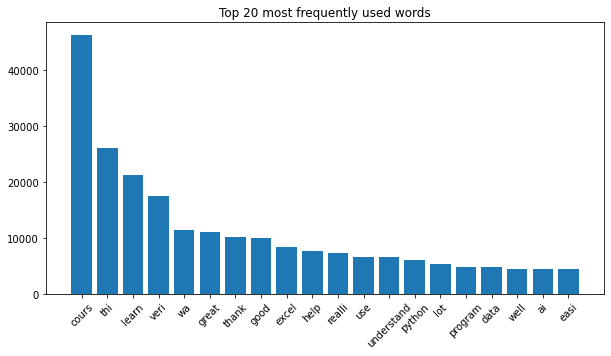

In [7]:
words_to_train_with = Counter(chain.from_iterable(train_balanced['tokens']))

# plot the top 20 most frequently used in words_to_train_with
plt.figure(figsize=(10,5))
plt.title('Top 20 most frequently used words')
plt.bar(*zip(*words_to_train_with.most_common(20)))
plt.xticks(rotation=45)
plt.show()

In [8]:
# make a tuple of tokens_keep and classification

def prepare_train_data(row):
    x = {token:True for token in row['tokens']}
    y = row['course_name']
    return (x, y)

train_data = train_balanced.apply(prepare_train_data, axis=1)
train_data[0]

({'highli': True,
  'recommend': True,
  'anyon': True,
  'want': True,
  'start': True,
  'learn': True,
  'ai': True,
  'explain': True,
  'coher': True,
  'intuit': True,
  'way': True,
  'help': True,
  'lay': True,
  'foundat': True,
  'lifelong': True,
  'experi': True,
  'new': True,
  'career': True},
 'ai-for-everyone')

In [9]:
model_nb = nltk.NaiveBayesClassifier.train(train_data)

In [10]:
model_nb.show_most_informative_features(25)

Most Informative Features
                  python = True           python : excel- =   2447.7 : 1.0
                      ai = True           ai-for : founda =   2126.3 : 1.0
                      dr = True           python : founda =    844.3 : 1.0
              cybersecur = True           introd : python =    633.0 : 1.0
                 barbara = True           learni : ai-for =    553.0 : 1.0
                   cyber = True           introd : python =    534.3 : 1.0
                 analyst = True           founda : python =    415.0 : 1.0
                   chuck = True           python : learni =    409.8 : 1.0
                   audio = True           introd : ai-for =    395.0 : 1.0
                  analyt = True           founda : learni =    390.2 : 1.0
                     web = True           python : founda =    389.4 : 1.0
                     ibm = True           introd : ai-for =    322.3 : 1.0
              procrastin = True           learni : excel- =    318.3 : 1.0

In [11]:
# make a def to predict the course name using the model_nb
def predict_course_name(row, model, words_to_train_with):
    x = {token:True for token in row['tokens'] if token in words_to_train_with}
    return model.classify(x)

test['predicted_course_name'] = test.apply(lambda row: predict_course_name(row, model_nb, words_to_train_with), axis=1)
test[['course_name', 'predicted_course_name']].sample(10)

,course_name,predicted_course_name
23338,foundations-data,foundations-data
51918,learning-how-to-learn,learning-how-to-learn
46867,python,python
6870,ai-for-everyone,learning-how-to-learn
26742,foundations-data,foundations-data
39131,python-network-data,python
46584,python,python
38640,python-network-data,introduction-cybersecurity-cyber-attacks
39277,python-network-data,python
22578,foundations-data,python


In [12]:
# calculate the accuracy of the model
accuracy = nltk.classify.accuracy(model_nb, train_data)
print('Accuracy of the model: %s' % f'{accuracy:.2%}')

Accuracy of the model: 47.31%


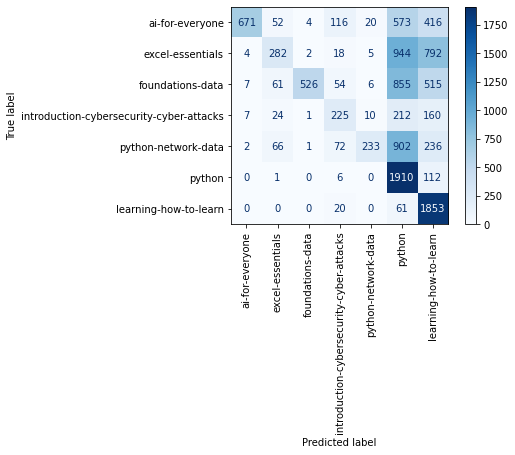

In [13]:
# calculate the confusion matrix of the model using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classification_labels = test['course_name'].unique()
cmx = confusion_matrix(test['course_name'], test['predicted_course_name'], labels=classification_labels)

ConfusionMatrixDisplay(confusion_matrix=cmx, display_labels=list(classification_labels)).plot( cmap='Blues',xticks_rotation='vertical')
plt.show()

In [14]:
# Make a dataframe that holds the confusion matrix
cmx_df = pd.DataFrame(cmx, index=classification_labels, columns=classification_labels)
cmx_df

,ai-for-everyone,excel-essentials,foundations-data,introduction-cybersecurity-cyber-attacks,python-network-data,python,learning-how-to-learn
ai-for-everyone,671,52,4,116,20,573,416
excel-essentials,4,282,2,18,5,944,792
foundations-data,7,61,526,54,6,855,515
introduction-cybersecurity-cyber-attacks,7,24,1,225,10,212,160
python-network-data,2,66,1,72,233,902,236
python,0,1,0,6,0,1910,112
learning-how-to-learn,0,0,0,20,0,61,1853


In [15]:
# calculate the precision, recall, f1-measure of the model
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(test['course_name'], test['predicted_course_name'], labels=classification_labels)

# average the precision, recall, f1-measure
precision_avg = np.average(precision)
recall_avg = np.average(recall)
f1_avg = np.average(f1)

# show the results
print('precision: %s \nrecall: %s \nf1-measure: %s' % (f'{precision_avg:.2%}', f'{recall_avg:.2%}', f'{f1_avg:.2%}'))

precision: 66.15% 
recall: 45.22% 
f1-measure: 42.00%


### SVM Model

In [50]:
df.query("star == '5'")['star'].value_counts()

5    55888
Name: star, dtype: int64

In [51]:
df.query("star != '5'")['star'].value_counts()

4    2956
3     775
1     302
2     265
Name: star, dtype: int64

In [ ]:
About Page...

pip freeze > requirements.txt

search Google for grepper to see what it does

In [20]:
def predicted_star(x_train, y_train):
    '''
    The idea behind the following code is from the following YouTube video:
    
    Rodolfo Moreira
    March 6, 2022
    https://www.youtube.com/watch?v=ep2e-adqxFI&ab_channel=DataProductsbyRodolfoMoreira
    '''
    x = x_train # train['raw_tokens']
    y = y_train # train['star']

    cv = CountVectorizer()
    base_features = cv.fit(x)
    features = cv.fit(x).transform(x)

    model_svm = svm.SVC()
    return model_svm.fit(features, y)

In [42]:
x = train.query("star != '5'")['raw_tokens']
y = train.query("star != '5'")['star']

cv = CountVectorizer()
base_features = cv.fit(x)
features = cv.fit(x).transform(x)

## NOTE: LinearSVC runs a lot faster than SVC

model_svm = svm.LinearSVC(class_weight='balanced')
model_svm.fit(features, y)

LinearSVC(class_weight='balanced')

In [43]:
features_test = base_features.transform(test['raw_tokens'])
print("Accuracy of the model: {}".format(model_svm.score(features_test, test['star'])))

Accuracy of the model: 0.04245243831519482


In [45]:
# Predict Star rating
predict_review = np.array(['This is the best class ever'])
review_series = pd.Series(predict_review, copy=False)
star_prediction = base_features.transform(review_series)
model_svm.predict(star_prediction)

array(['2'], dtype=object)